Наша команда:
    Синицин Олег 11-703
    Смоленцев Андрей 11-703
    Алексеев Владислав 11-703
    Гарифуллин Ильяс 11-703

Описание данных:
    sales_train.csv - обучающий набор. Ежедневные исторические данные с января 2013 года по октябрь 2015 года.
    test.csv - тестовый набор. Вам необходимо спрогнозировать продажи этих магазинов и продуктов на ноябрь 2015 года.
    sample_submission.csv - файл с примерами представления в правильном формате.
    items.csv - дополнительная информация о товарах / товарах.
    item_categories.csv - дополнительная информация о категориях товаров.
    shops.csv- дополнительная информация о магазинах.
    
   Поля:
    ID - идентификатор, который представляет кортеж (магазин, товар) в тестовом наборе
    shop_id - уникальный идентификатор магазина
    item_id - уникальный идентификатор товара
    item_category_id - уникальный идентификатор категории товара
    item_cnt_day - количество проданных товаров. Вы прогнозируете ежемесячную сумму этой меры
    item_price - текущая цена товара
    date - дата в формате дд / мм / гггг
        date_block_num - порядковый номер месяца, используемый для удобства. В январе 2013 года - 0, в феврале 2013 года - 1, ..., в октябре 2015 года - 33
    item_name - название элемента
    shop_name - название магазина
    item_category_name - название категории товара
 Задача:
     Задача состоит в прогнозировании общего количества продуктов, проданных в каждом магазине для тестового набора.
     

In [1]:
import numpy as np
import pandas as pd
import sklearn
import nltk
import datetime


In [2]:
train_df = pd.read_csv(r"C:\Users\oleji\Desktop\input\sales_train.csv")
test_df = pd.read_csv(r"C:\Users\oleji\Desktop\input\\test.csv")
submission_df = pd.read_csv(r"C:\Users\oleji\Desktop\input\sample_submission.csv")
items_df = pd.read_csv(r"C:\Users\oleji\Desktop\input\items.csv")
item_categories_df = pd.read_csv(r"C:\Users\oleji\Desktop\input\item_categories.csv")
shops_df = pd.read_csv(r"C:\Users\oleji\Desktop\input\shops.csv")

Рассмотрим начальное содержимое данных.

In [3]:
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
test_df.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [5]:
submission_df.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [6]:
items_df.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [7]:
item_categories_df.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [8]:
shops_df.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [9]:
#перевод данных в месячные данные
train_df['date'] = pd.to_datetime(train_df['date'], format='%d.%m.%Y')
train_df['month'] = train_df['date'].dt.month
train_df['year'] = train_df['date'].dt.year
train_df = train_df.drop(['date', 'item_price'], axis=1)
train_df = train_df.groupby([c for c in train_df.columns if c not in ['item_cnt_day']], as_index=False)[['item_cnt_day']].sum()
train_df = train_df.rename(columns={'item_cnt_day':'item_cnt_month'})

#Среднемесечные
shop_item_monthly_mean = train_df[['shop_id', 'item_id', 'item_cnt_month']].groupby(['shop_id', 'item_id'], as_index=False)[['item_cnt_month']].mean()
shop_item_monthly_mean = shop_item_monthly_mean.rename(columns={'item_cnt_month':'item_cnt_month_mean'})

#Добавим среднее значение
train_df = pd.merge(train_df, shop_item_monthly_mean, how='left', on=['shop_id', 'item_id'])
train_df.head()

,date_block_num,shop_id,item_id,month,year,item_cnt_month,item_cnt_month_mean
0,0,0,32,1,2013,6.0,8.0
1,0,0,33,1,2013,3.0,3.0
2,0,0,35,1,2013,1.0,7.5
3,0,0,43,1,2013,1.0,1.0
4,0,0,51,1,2013,2.0,2.5


In [10]:
#Последний месяц продаж : Oct 2015
shop_item_prev_month = train_df[train_df['date_block_num'] == 33][['shop_id', 'item_id', 'item_cnt_month']]
shop_item_prev_month = shop_item_prev_month.rename(columns={'item_cnt_month':'item_cnt_prev_month'})
shop_item_prev_month.head()

,shop_id,item_id,item_cnt_prev_month
1577593,2,31,1.0
1577594,2,486,3.0
1577595,2,787,1.0
1577596,2,794,1.0
1577597,2,968,1.0


In [11]:
#Добавим вышеуказанные данные предыдущего месяца
train_df = pd.merge(train_df, shop_item_prev_month, how='left', on=['shop_id', 'item_id'])
train_df.head()

,date_block_num,shop_id,item_id,month,year,item_cnt_month,item_cnt_month_mean,item_cnt_prev_month
0,0,0,32,1,2013,6.0,8.0,NaN
1,0,0,33,1,2013,3.0,3.0,NaN
2,0,0,35,1,2013,1.0,7.5,NaN
3,0,0,43,1,2013,1.0,1.0,NaN
4,0,0,51,1,2013,2.0,2.5,NaN


In [12]:
train_df = train_df.fillna(0.)
train_df.head()

,date_block_num,shop_id,item_id,month,year,item_cnt_month,item_cnt_month_mean,item_cnt_prev_month
0,0,0,32,1,2013,6.0,8.0,0.0
1,0,0,33,1,2013,3.0,3.0,0.0
2,0,0,35,1,2013,1.0,7.5,0.0
3,0,0,43,1,2013,1.0,1.0,0.0
4,0,0,51,1,2013,2.0,2.5,0.0


Добавим к выборке сам предмет, категорию и название магазина, в котором данный предмет продавался в текущий момент времени.

In [13]:

train_df = pd.merge(train_df, items_df, how='left', on='item_id')
train_df.head()

,date_block_num,shop_id,item_id,month,year,item_cnt_month,item_cnt_month_mean,item_cnt_prev_month,item_name,item_category_id
0,0,0,32,1,2013,6.0,8.0,0.0,1+1,40
1,0,0,33,1,2013,3.0,3.0,0.0,1+1 (BD),37
2,0,0,35,1,2013,1.0,7.5,0.0,10 ЛЕТ СПУСТЯ,40
3,0,0,43,1,2013,1.0,1.0,0.0,100 МИЛЛИОНОВ ЕВРО,40
4,0,0,51,1,2013,2.0,2.5,0.0,100 лучших произведений классики (mp3-CD) (Dig...,57


In [14]:
train_df = pd.merge(train_df, item_categories_df, how='left', on=['item_category_id'])
train_df.head()

,date_block_num,shop_id,item_id,month,year,item_cnt_month,item_cnt_month_mean,item_cnt_prev_month,item_name,item_category_id,item_category_name
0,0,0,32,1,2013,6.0,8.0,0.0,1+1,40,Кино - DVD
1,0,0,33,1,2013,3.0,3.0,0.0,1+1 (BD),37,Кино - Blu-Ray
2,0,0,35,1,2013,1.0,7.5,0.0,10 ЛЕТ СПУСТЯ,40,Кино - DVD
3,0,0,43,1,2013,1.0,1.0,0.0,100 МИЛЛИОНОВ ЕВРО,40,Кино - DVD
4,0,0,51,1,2013,2.0,2.5,0.0,100 лучших произведений классики (mp3-CD) (Dig...,57,Музыка - MP3


In [15]:
train_df = pd.merge(train_df, shops_df, how='left', on=['shop_id'])
train_df.head()

,date_block_num,shop_id,item_id,month,year,item_cnt_month,item_cnt_month_mean,item_cnt_prev_month,item_name,item_category_id,item_category_name,shop_name
0,0,0,32,1,2013,6.0,8.0,0.0,1+1,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"
1,0,0,33,1,2013,3.0,3.0,0.0,1+1 (BD),37,Кино - Blu-Ray,"!Якутск Орджоникидзе, 56 фран"
2,0,0,35,1,2013,1.0,7.5,0.0,10 ЛЕТ СПУСТЯ,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"
3,0,0,43,1,2013,1.0,1.0,0.0,100 МИЛЛИОНОВ ЕВРО,40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"
4,0,0,51,1,2013,2.0,2.5,0.0,100 лучших произведений классики (mp3-CD) (Dig...,57,Музыка - MP3,"!Якутск Орджоникидзе, 56 фран"


Проведем ниже исследования над тестовой выборкой последнего месяца.

In [16]:
test_df['month'] = 11
test_df['year'] = 2015
test_df['date_block_num'] = 34
test_df.head()

,ID,shop_id,item_id,month,year,date_block_num
0,0,5,5037,11,2015,34
1,1,5,5320,11,2015,34
2,2,5,5233,11,2015,34
3,3,5,5232,11,2015,34
4,4,5,5268,11,2015,34


Добавим средние значения.

In [17]:

shop_item_monthly_mean.head()



,shop_id,item_id,item_cnt_month_mean
0,0,30,31.0
1,0,31,11.0
2,0,32,8.0
3,0,33,3.0
4,0,35,7.5


Проверим значение наличие средних продаж вещей в основной выборке, например вещь с Id 5320

In [18]:
test_df = pd.merge(test_df, shop_item_monthly_mean, how='left', on=['shop_id', 'item_id'])
test_df.head()

,ID,shop_id,item_id,month,year,date_block_num,item_cnt_month_mean
0,0,5,5037,11,2015,34,1.444444
1,1,5,5320,11,2015,34,NaN
2,2,5,5233,11,2015,34,2.000000
3,3,5,5232,11,2015,34,1.000000
4,4,5,5268,11,2015,34,NaN


In [19]:
5320 in train_df.item_id.values

False

In [20]:
5233 in train_df.item_id.values

True

Предмета с Id 5320 не оказалось. Добавим к данным кол-во проданных предметов за прошлый месяц.

In [21]:
test_df = pd.merge(test_df, shop_item_prev_month, how='left', on=['shop_id', 'item_id'])
test_df.head()

,ID,shop_id,item_id,month,year,date_block_num,item_cnt_month_mean,item_cnt_prev_month
0,0,5,5037,11,2015,34,1.444444,NaN
1,1,5,5320,11,2015,34,NaN,NaN
2,2,5,5233,11,2015,34,2.000000,1.0
3,3,5,5232,11,2015,34,1.000000,NaN
4,4,5,5268,11,2015,34,NaN,NaN


In [22]:
test_df = pd.merge(test_df, items_df, how='left', on='item_id')
test_df.head()

,ID,shop_id,item_id,month,year,date_block_num,item_cnt_month_mean,item_cnt_prev_month,item_name,item_category_id
0,0,5,5037,11,2015,34,1.444444,NaN,"NHL 15 [PS3, русские субтитры]",19
1,1,5,5320,11,2015,34,NaN,NaN,ONE DIRECTION Made In The A.M.,55
2,2,5,5233,11,2015,34,2.000000,1.0,"Need for Speed Rivals (Essentials) [PS3, русск...",19
3,3,5,5232,11,2015,34,1.000000,NaN,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23
4,4,5,5268,11,2015,34,NaN,NaN,"Need for Speed [PS4, русская версия]",20


In [23]:
#Item Category features
test_df = pd.merge(test_df, item_categories_df, how='left', on='item_category_id')
#Shops features
test_df = pd.merge(test_df, shops_df, how='left', on='shop_id')
test_df = test_df.fillna(0.)
test_df['item_cnt_month'] = 0.
test_df.head()

,ID,shop_id,item_id,month,year,date_block_num,item_cnt_month_mean,item_cnt_prev_month,item_name,item_category_id,item_category_name,shop_name,item_cnt_month
0,0,5,5037,11,2015,34,1.444444,0.0,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",0.0
1,1,5,5320,11,2015,34,0.000000,0.0,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"Вологда ТРЦ ""Мармелад""",0.0
2,2,5,5233,11,2015,34,2.000000,1.0,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",0.0
3,3,5,5232,11,2015,34,1.000000,0.0,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360,"Вологда ТРЦ ""Мармелад""",0.0
4,4,5,5268,11,2015,34,0.000000,0.0,"Need for Speed [PS4, русская версия]",20,Игры - PS4,"Вологда ТРЦ ""Мармелад""",0.0


In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

train_test_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
print("train_df.shape = {}, test_df.shape = {}, train_test_df.shape = {}".format(train_df.shape, test_df.shape, train_test_df.shape))
stores_hm = train_test_df.pivot_table(index='shop_id', columns='item_category_id', values='item_cnt_month', aggfunc='count', fill_value=0)
print("stores_hm.shape = {}".format(stores_hm.shape))
stores_hm.tail()

D:\Users\oleji\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


train_df.shape = (1609124, 12), test_df.shape = (214200, 13), train_test_df.shape = (1823324, 13)
stores_hm.shape = (60, 84)


item_category_id,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
shop_id,,,,,,,,,,,,,,,,,,,,,
55,1,0,10,28,0,4,9,24,36,8,...,22,44,1503,16,1692,1,3,0,0,4
56,1,0,234,229,31,123,251,62,9,8,...,1,254,61,98,49,25,9,23,53,59
57,1,0,302,281,47,148,266,117,4,8,...,1,977,61,151,49,20,0,14,31,85
58,1,0,218,243,41,111,246,80,1,8,...,1,569,61,82,49,17,0,12,33,61
59,1,0,174,199,27,54,165,73,6,8,...,1,369,61,20,49,20,5,0,0,110


Произведем ниже первичный визуальный анализ с помощью heatmap, тем самым рассмотрим показатели продаж тех или иных категорий товаров в разных магазинах. Рассмотрим разницу показателей в основной и тестовой выборке.

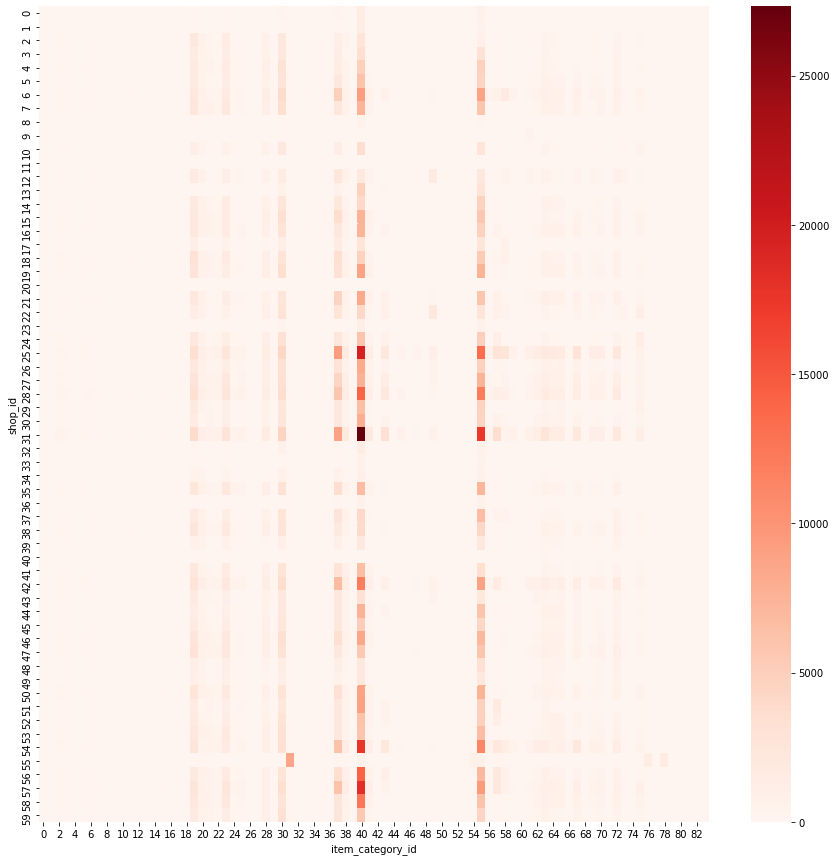

In [25]:
#Heatmap of "item_cnt_month" in "shop_id and item_category_id" in "train_test_df"
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(stores_hm, ax=ax, cbar=True,cmap=plt.cm.Reds)

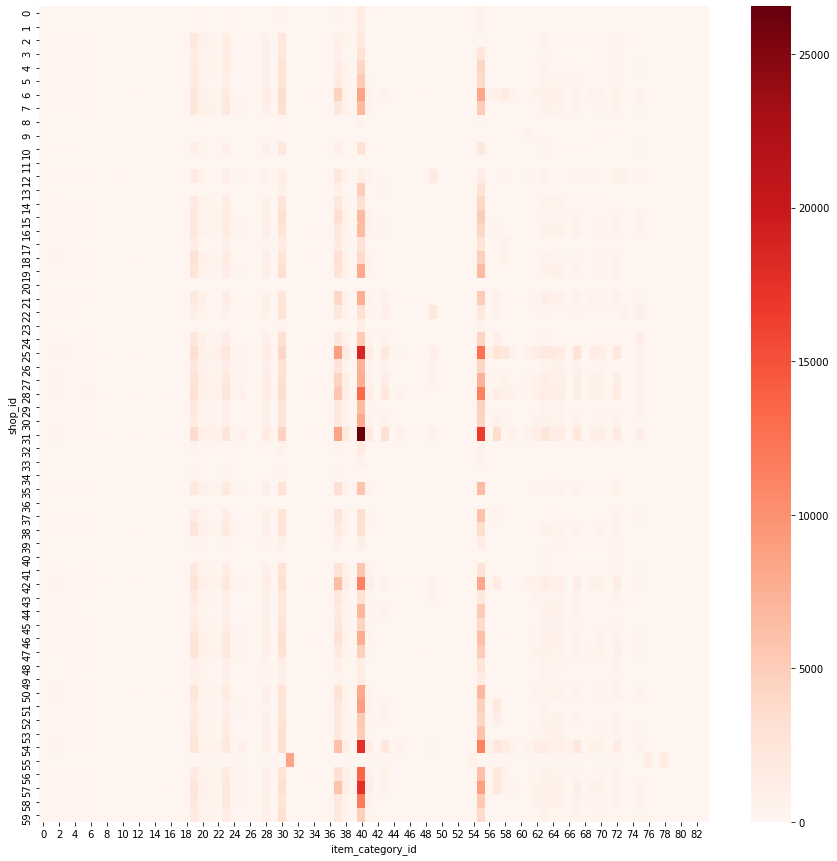

In [26]:
#Heatmap of "item_cnt_month" in "shop_id vs item_category_id" in "train_df"
stores_hm = train_df.pivot_table(index='shop_id', columns='item_category_id', values='item_cnt_month', aggfunc='count', fill_value=0)
_, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(stores_hm, ax=ax, cbar=True,cmap=plt.cm.Reds)

In [27]:
print(train_df['shop_id'], train_df['shop_name'])
print('*'*80)
test_df.head()


0           0
1           0
2           0
3           0
4           0
5           0
6           0
7           0
8           0
9           0
10          0
11          0
12          0
13          0
14          0
15          0
16          0
17          0
18          0
19          0
20          0
21          0
22          0
23          0
24          0
25          0
26          0
27          0
28          0
29          0
           ..
1609094    59
1609095    59
1609096    59
1609097    59
1609098    59
1609099    59
1609100    59
1609101    59
1609102    59
1609103    59
1609104    59
1609105    59
1609106    59
1609107    59
1609108    59
1609109    59
1609110    59
1609111    59
1609112    59
1609113    59
1609114    59
1609115    59
1609116    59
1609117    59
1609118    59
1609119    59
1609120    59
1609121    59
1609122    59
1609123    59
Name: shop_id, Length: 1609124, dtype: int64 0          !Якутск Орджоникидзе, 56 фран
1          !Якутск Орджоникидзе, 56 фран
2          !Якутск 

,ID,shop_id,item_id,month,year,date_block_num,item_cnt_month_mean,item_cnt_prev_month,item_name,item_category_id,item_category_name,shop_name,item_cnt_month
0,0,5,5037,11,2015,34,1.444444,0.0,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",0.0
1,1,5,5320,11,2015,34,0.000000,0.0,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"Вологда ТРЦ ""Мармелад""",0.0
2,2,5,5233,11,2015,34,2.000000,1.0,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"Вологда ТРЦ ""Мармелад""",0.0
3,3,5,5232,11,2015,34,1.000000,0.0,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360,"Вологда ТРЦ ""Мармелад""",0.0
4,4,5,5268,11,2015,34,0.000000,0.0,"Need for Speed [PS4, русская версия]",20,Игры - PS4,"Вологда ТРЦ ""Мармелад""",0.0


Так как среди данных имеются названия товаров или магазинов с числами или числовыми выражениями, то приведем их к строчноому типу.

In [28]:
for c in ['shop_name', 'item_category_name', 'item_name']:
    le = sklearn.preprocessing.LabelEncoder()
    le.fit(list(train_df[c].unique()) + list(test_df[c].unique()))
    train_df[c] = le.transform(train_df[c].astype(str))
    test_df[c] = le.transform(test_df[c].astype(str))
    print(c)

shop_name
item_category_name
item_name


Random forest  — алгоритм машинного обучения, предложенный Лео Брейманом и Адель Катлер, заключающийся в использовании комитета (ансамбля) решающих деревьев. Алгоритм сочетает в себе две основные идеи: метод бэггинга Бреймана, и метод случайных подпространств, предложенный Tin Kam Ho. Алгоритм применяется для задач классификации, регрессии и кластеризации. Основная идея заключается в использовании большого ансамбля решающих деревьев, каждое из которых само по себе даёт очень невысокое качество классификации, но за счёт их большого количества результат получается хорошим.

Вычислим ниже средне квадратичную ошибку валидации. А также точность оценки для основной выборки без определения наиболее важных переменных.

In [29]:
feature_list = [c for c in train_df.columns if c not in 'item_cnt_month']
#Validation hold out month is 33
x1 = train_df[train_df['date_block_num'] < 33]
y1 = np.log1p(x1['item_cnt_month'].clip(0., 20.))
x1 = x1[feature_list]
x2 = train_df[train_df['date_block_num'] == 33]
y2 = np.log1p(x2['item_cnt_month'].clip(0., 20.))
x2 = x2[feature_list]

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=25, random_state=42, max_depth=15, n_jobs=-1)
rf.fit(x1, y1)
print("RMSE on Validation hold out month 33: {}".format(np.sqrt(sklearn.metrics.mean_squared_error(y2.clip(0., 20.), rf.predict(x2).clip(0., 20.)))))

#Full train
rf.fit(train_df[feature_list], train_df['item_cnt_month'].clip(0., 20.))
print("Accuracy on training data without considering variable importances:{}".format(round(rf.score(train_df[feature_list], train_df['item_cnt_month'].clip(0., 20.))*100, 2)))

#predict
test_df['item_cnt_month'] = rf.predict(test_df[feature_list]).clip(0., 20.)

#create submission file
test_df[['ID', 'item_cnt_month']].to_csv('submission.csv', index=False)

RMSE on Validation hold out month 33: 0.2776399929814023
Accuracy on training data without considering variable importances:68.15


Построим дерево решений и рандомный лес.

In [30]:
from sklearn.tree import export_graphviz
import pydot
from IPython.display import Image

In [31]:
'''tree = rf.estimators_[3]
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')
Image(filename='tree.png')'''

"tree = rf.estimators_[3]\nexport_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)\n(graph, ) = pydot.graph_from_dot_file('tree.dot')\ngraph.write_png('tree.png')\nImage(filename='tree.png')"

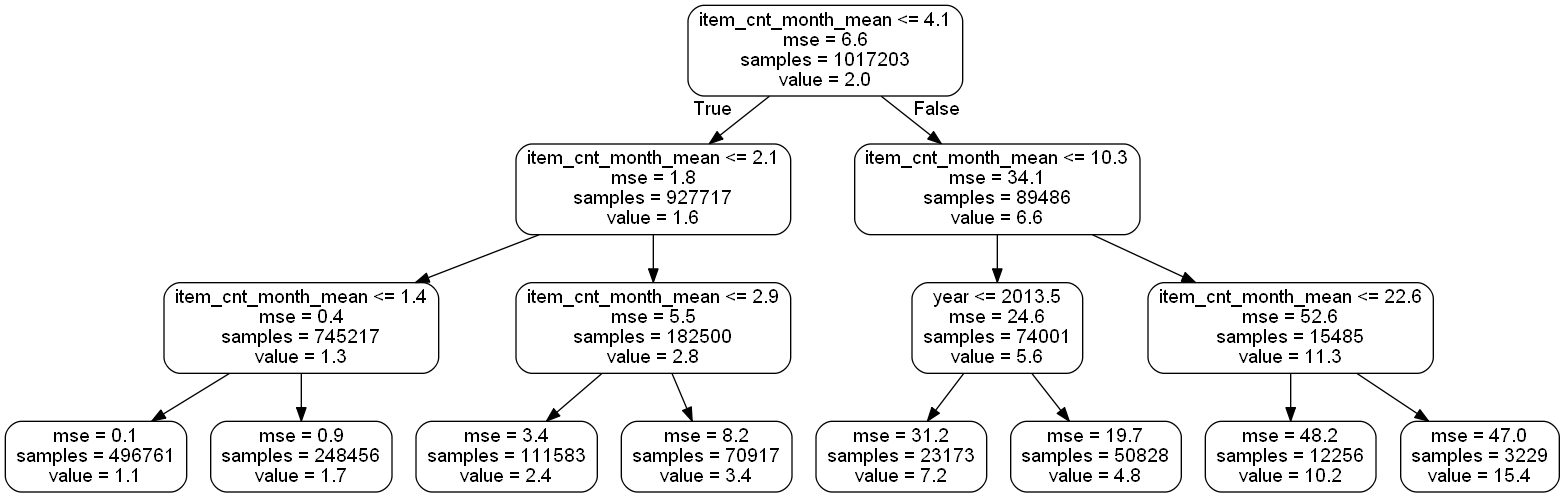

In [32]:

rf_small = RandomForestRegressor(n_estimators=2, random_state=42, max_depth=3, n_jobs=-1)
rf_small.fit(train_df[feature_list], train_df['item_cnt_month'].clip(0., 20.))
small_tree = rf_small.estimators_[1]
export_graphviz(small_tree, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png')
Image(filename='small_tree.png')

Случайные леса, получаемые в результате применения техник, описанных ранее, могут быть естественным образом использованы для оценки важности переменных в задачах регрессии и классификации. Следующий способ такой оценки был описан Breiman.

Первый шаг в оценке важности переменной в тренировочном наборе — тренировка случайного леса на этом наборе. Во время процесса построения модели для каждого элемента тренировочного набора называемая out-of-bag-ошибка (ошибка на неотобранных образцах). Затем для каждой сущности такая ошибка усредняется по всему случайному лесу.

Для того, чтобы оценить важность j-го параметра после тренировки, значения j-го параметра перемешиваются для всех записей тренировочного набора и out-of-bag-ошибка считается снова. Важность параметра оценивается путём усреднения по всем деревьям разности показателей out-of-bag-ошибок до и после перемешивания значений. При этом значения таких ошибок нормализуются на стандартное отклонение.

Параметры выборки, которые дают бо́льшие значения, считаются более важными для тренировочного набора. Метод имеет следующий потенциальный недостаток — для категориальных переменных с большим количеством значений метод склонен считать такие переменные более важными. Частичное перемешивание значений в этом случае может снижать влияние этого эффекта. Из групп коррелирующих параметров, важность которых оказывается одинаковой, выбираются меньшие по численности группы.

Выбор наиболее важных переменных.
    Чтобы оценить полезность всех переменных во всем рандомном лесу, изначально можно посмотреть на их относительную важность.

In [33]:
# Получаем числовые значения переменных
importances = list(rf.feature_importances_)

# Кортежи с названием переменной и ее важностью
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Сортируем переменные по убыванию важности
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)


[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: item_cnt_month_mean  Importance: 0.72
Variable: date_block_num       Importance: 0.1
Variable: item_id              Importance: 0.04
Variable: item_name            Importance: 0.04
Variable: item_cnt_prev_month  Importance: 0.03
Variable: item_category_id     Importance: 0.02
Variable: item_category_name   Importance: 0.02
Variable: shop_id              Importance: 0.01
Variable: year                 Importance: 0.01
Variable: shop_name            Importance: 0.01


Чтобы визуально оценить важность переменных построим для этого гистограмму.

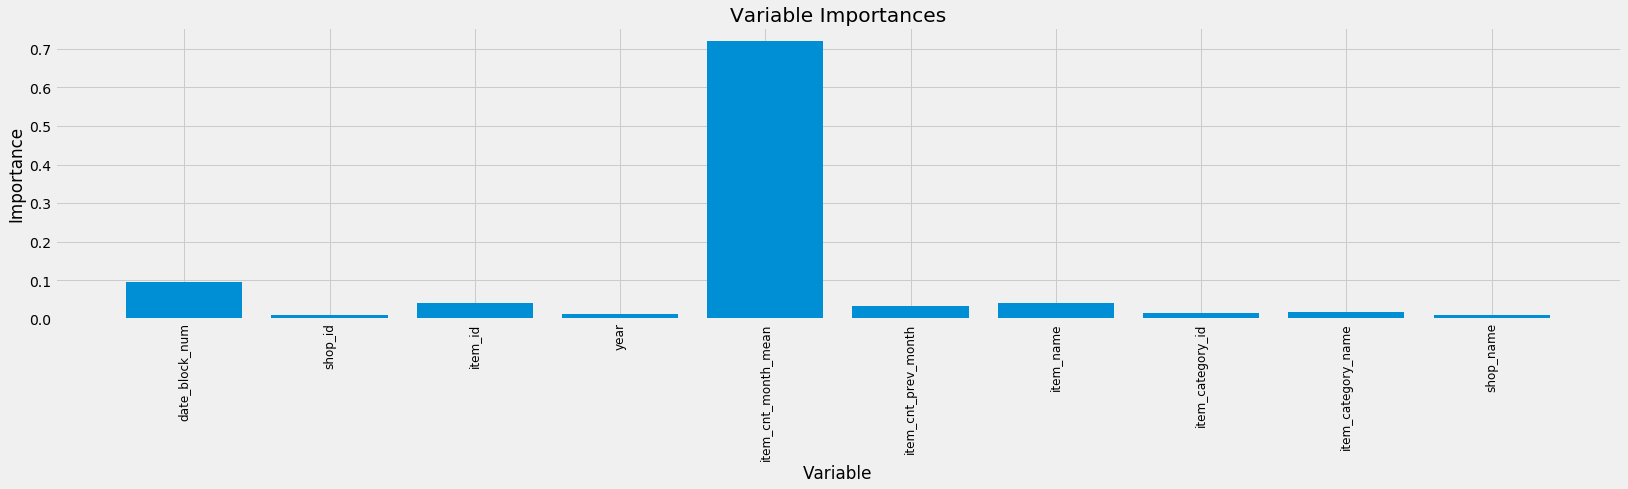

In [34]:

plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(25, 5))
ax = fig.add_subplot(111)

x_values = list(range(len(importances)))

ax.bar(x_values, importances, orientation = 'vertical')

plt.xticks(x_values, feature_list, rotation='vertical', fontsize=12)

plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

Имея теперь список наиболее важных переменных построим новый рандомный лес.

In [35]:
rf_most_important = RandomForestRegressor(n_estimators=30, random_state=42, max_depth=20, n_jobs=-1)


important_features = ['item_cnt_month_mean', 'date_block_num', 'item_cnt_prev_month', 'item_id', 'item_name']


rf_most_important.fit(train_df[important_features], train_df['item_cnt_month'].clip(0., 20.))
print("Accuracy on training data considering variable importances:{}".format(round(rf_most_important.score(train_df[important_features], train_df['item_cnt_month'].clip(0., 20.))*100, 2)))

#predict
test_df['item_cnt_month'] = rf_most_important.predict(test_df[important_features]).clip(0., 20.)


test_df[['ID', 'item_cnt_month']].to_csv('submission_variable_importance.csv', index=False)

Accuracy on training data considering variable importances:80.87


PermissionError: [Errno 13] Permission denied: 'submission_variable_importance.csv'